In [1]:
import os
import csv
import pandas as pd
import plotly.express as px
import sklearn
import matplotlib.pyplot as plt
import numpy as np

EARTHQUAKE_PATH = "datasets/earthquakes.csv"
MAPBOX_ACCESS_KEY = os.environ['MAPBOX_KEY']

# READ EARTHQUAKE CSV FILE
def load_earthquake_data(earthquake_path = EARTHQUAKE_PATH):
    return pd.read_csv(earthquake_path)

# IMPORT DATA AS PANDAS DATAFRAME
df = load_earthquake_data()

In [2]:
### RAW DATA INFO ###
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

### The raw data contains many features, but many of these features cannot be read or have many missing values. Training algorithms do not handle missing data well, so we must either transform features by filling in the missing data points with their median or drop them. Here we decide to drop the columns with many missing data points because either there were too many missing values or the data wasn't significant. 

In [3]:
### DATA CLEANING ###
# Machine learning algorithms do not function appropriately with missing values.

# 1) Dropping columns with many missing feautres.
incomplete_features=['Depth Error', 'Depth Seismic Stations', 'Magnitude Error', 'Magnitude Seismic Stations', 
                    'Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square']
df.drop(incomplete_features, axis=1, inplace=True)

# 2) Dropping rows where magnitude type is missing.
df.dropna(axis=0, how='any', inplace=True)

df.info()

# Data reduction by approx. 33%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23409 entries, 0 to 23411
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              23409 non-null  object 
 1   Time              23409 non-null  object 
 2   Latitude          23409 non-null  float64
 3   Longitude         23409 non-null  float64
 4   Type              23409 non-null  object 
 5   Depth             23409 non-null  float64
 6   Magnitude         23409 non-null  float64
 7   Magnitude Type    23409 non-null  object 
 8   ID                23409 non-null  object 
 9   Source            23409 non-null  object 
 10  Location Source   23409 non-null  object 
 11  Magnitude Source  23409 non-null  object 
 12  Status            23409 non-null  object 
dtypes: float64(4), object(9)
memory usage: 2.5+ MB


### Some features are non-numerical so we convert them to a numerical type.

In [4]:
from sklearn.preprocessing import OrdinalEncoder
### DATA TYPE CONVERSION ###

# Date Conversions
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y', errors = 'raise') 
df['Time'] = pd.to_datetime(df['Time'], format = '%H:%M:%S', errors = 'raise')
# Appending Year, Month, and Date column
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day
df['Day of Year'] = pd.DatetimeIndex(df['Date']).dayofyear

#Appending Hour, Minute, and Second column
df['Hour'] = pd.DatetimeIndex(df['Time']).hour
df['Minute'] = pd.DatetimeIndex(df['Time']).minute
df['Second'] = pd.DatetimeIndex(df['Time']).second

# Enumerating Categorical Types
ordinal_encoder = OrdinalEncoder()
df['Type'] = ordinal_encoder.fit_transform(df[['Type']])
df['Magnitude Type'] = ordinal_encoder.fit_transform(df[['Magnitude Type']])
df['Location Source'] = ordinal_encoder.fit_transform(df[['Location Source']])
df['Source'] = ordinal_encoder.fit_transform(df[['Source']])
df['Magnitude Source'] = ordinal_encoder.fit_transform(df[['Magnitude Source']])
df['Status'] = ordinal_encoder.fit_transform(df[['Status']])

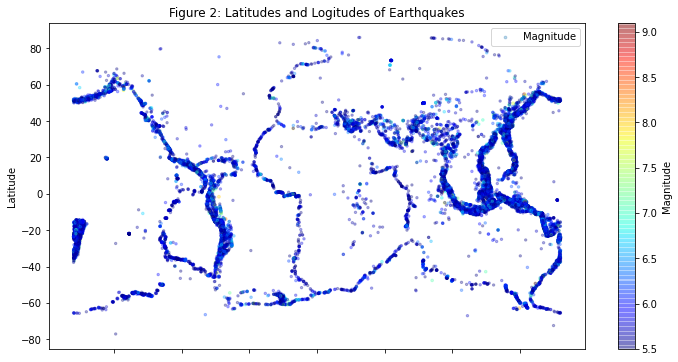

In [5]:
# Visualizing Geographical Data
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.3, figsize=(12,6), title="Figure 2: Latitudes and Logitudes of Earthquakes",
       s=df['Magnitude'], label='Magnitude', c='Magnitude', cmap=plt.get_cmap('jet'), colorbar=True,)
plt.legend()

# Display raw data on world map
px.set_mapbox_access_token(MAPBOX_ACCESS_KEY)
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Magnitude", size="Magnitude",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=5, zoom=0, title="Figure 1: Significant Earthquakes from 1965 to 2016")
fig.show()

### Let's begin to analyize our dataset. 
#### We hypothesized that depth and magnitude were strongly positvely correlated.

<AxesSubplot:xlabel='Depth', ylabel='Magnitude'>

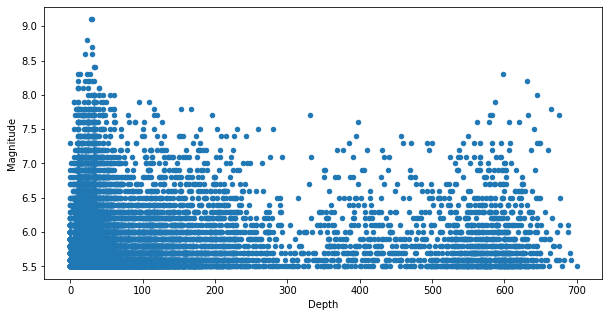

In [104]:
# Looking for Correlations
df.plot.scatter('Depth','Magnitude', figsize=(10,5))

### Let's apply a linear-classifier

Coefficients: 
 [[0.04967809]]
Mean squared error: 873.03
Coefficient of determination: 0.04


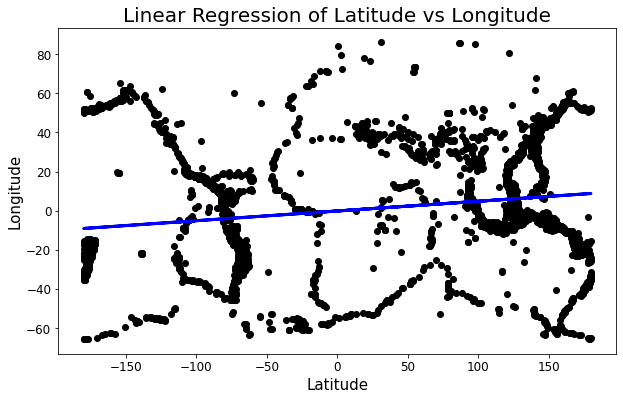

In [6]:
### Scikit-Learn Linear Models ###
### Proving our data set is non-linear using linear regression ###
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

x_lables = ['Longitude']
y_labels = ['Latitude']
X_train, X_test, y_train, y_test = train_test_split(df[x_lables], df[y_labels], test_size=0.2, random_state=42)

# Create linear regression object
lin_reg = linear_model.LinearRegression()

# Train the model using the training sets
lin_reg.fit(X_train, y_train)

# Make predictions using the testing set
lin_reg_pred = lin_reg.predict(X_test)

print('Coefficients: \n', lin_reg.coef_) # COE
print('Mean squared error: %.2f' % mean_squared_error(y_test, lin_reg_pred)) # MSE
print('Coefficient of determination: %.2f' % r2_score(y_test, lin_reg_pred)) # COD

# Plot outputs
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, lin_reg_pred, color='blue', linewidth=3)
plt.title('Linear Regression of Latitude vs Longitude', fontsize = 20)
plt.xlabel('Latitude', fontsize=15)
plt.ylabel('Longitude', fontsize=15)
plt.tick_params(axis='both', labelsize=12)


#Simple linear regression shows just how non-linear our data is. A coefficient of determination of 0.004 tells
#    us that our data is strongly non-linear. Perfect linearlity would occur at 1.0 COE. Therefore, we must 
#    apply non-linear regression algorithms in order to properly model this data.

### Feature Scaling

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Select data for scaling
earthquake_data = df[['Latitude', 'Longitude', 'Depth', 'Day of Year', 'Type']]
labels = df['Magnitude'] # We don't scale the output label.
attribs = list(earthquake_data)

# Standardize the earthquake data // PCA
ct = ColumnTransformer([("num", StandardScaler(), attribs)])
earthquake_prepared = ct.fit_transform(earthquake_data)

X_train, X_test, y_train, y_test = train_test_split(earthquake_prepared, labels, test_size=0.2, random_state=42)

#    _________________________________________________________
#                    |       DATA:              LABELS:       
#    _________________________________________________________
#    TRAINING SET:   |   X_train(18727, 5)  y_train(18727, 1) 
#    VALIDATION SET: |    X_test(4682, 5)    y_test(4682, 1)
#    _________________________________________________________

#### Prepare to test models using cross validation

In [7]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

### Supervised Learning: Random Forest Regressor

In [109]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=500, n_jobs=-1)
forest_reg.fit(X_train, y_train)

scores = cross_val_score(forest_reg, earthquake_prepared, labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [0.47113646 0.42670635 0.41869313 0.41630451 0.40867123 0.43211576
 0.42459932 0.42761469 0.42188727 0.4560193 ]
Mean: 0.4303748009724986
Standard Deviation: 0.018039216854685496


### MLP Regressor

In [110]:
from sklearn.neural_network import MLPRegressor

mlp_regr = MLPRegressor(random_state=42, max_iter=5000)
mlp_regr.fit(earthquake_prepared, labels)

scores = cross_val_score(mlp_regr, earthquake_prepared, labels, scoring="neg_mean_squared_error", cv=10)
regr_scores = np.sqrt(-scores)

display_scores(regr_scores)

Scores: [0.47191183 0.41137077 0.41468414 0.41009391 0.41058189 0.43395532
 0.42342223 0.41651116 0.42143475 0.44638114]
Mean: 0.42603471476688515
Standard Deviation: 0.01880657146483633


### Finally, lets train a neural network to predict the expceted magnitue of an earthquake.
#### Inputs
- Latitude, Latitude^2, sin(Latitude)
- Longitude, Longitude^2, sin(Latitude)
- Depth, Depth Squared
- Day of Year
- Type

#### Hidden Layers
- Layer 1: 50 Neurons
- Layer 2: 50 Neurons

#### Output
- Magnitude

In [12]:
import math
earthquake_data = df[['Latitude', 'Longitude', 'Depth', 'Day of Year', 'Type']]
earthquake_data.loc[:, 'Lat^2'] = earthquake_data.loc[:, 'Latitude'].map(lambda lat: lat ** 2)
earthquake_data.loc[:, 'Lon^2'] = earthquake_data.loc[:, 'Longitude'].map(lambda lon: lon ** 2)
earthquake_data.loc[:, 'sin(Lat)'] = earthquake_data.loc[:, 'Latitude'].map(lambda lat: math.sin(lat))
earthquake_data.loc[:, 'sin(Lon)'] = earthquake_data.loc[:, 'Longitude'].map(lambda lon: math.sin(lon))
earthquake_data.loc[:, 'Depth^2' ] = earthquake_data.loc[:, 'Depth'].map(lambda dpth: dpth ** 2)


In [13]:
earthquake_data.head()

Latitude  Longitude  Depth  Day of Year  Type        Lat^2         Lon^2  \
0    19.246    145.616  131.6            2   0.0   370.408516  21204.019456   
1     1.863    127.352   80.0            4   0.0     3.470769  16218.531904   
2   -20.579   -173.972   20.0            5   0.0   423.495241  30266.256784   
3   -59.076    -23.557   15.0            8   0.0  3489.973776    554.932249   
4    11.938    126.427   15.0            9   0.0   142.515844  15983.786329   

   sin(Lat)  sin(Lon)   Depth^2  
0  0.386141  0.892446  17318.56  
1  0.957611  0.993105   6400.00  
2 -0.987442  0.926275    400.00  
3 -0.576354  0.999988    225.00  
4 -0.587827  0.691305    225.00

<AxesSubplot:title={'center':'Longitude vs Latitude'}, xlabel='Longitude', ylabel='Latitude'>

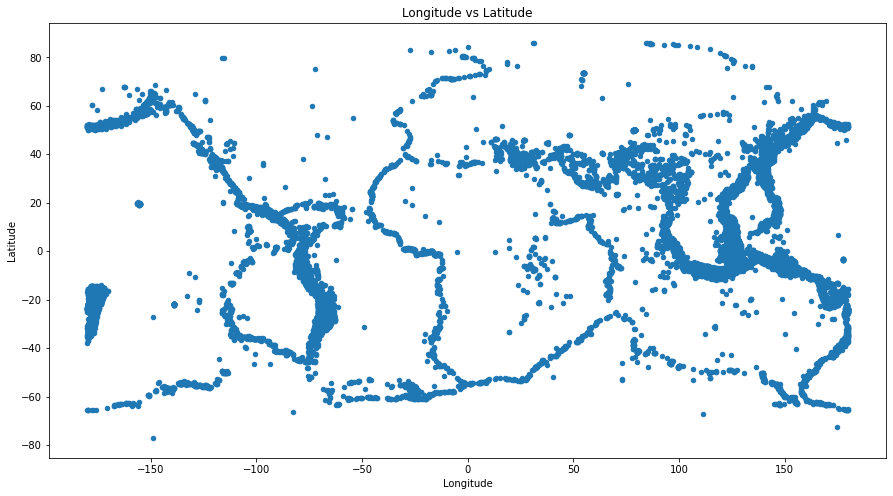

In [14]:
earthquake_data.plot.scatter(x='Longitude', y='Latitude', figsize=(15, 8), title='Longitude vs Latitude')

<AxesSubplot:title={'center':'Longitude^2 vs Latitude^2'}, xlabel='Lon^2', ylabel='Lat^2'>

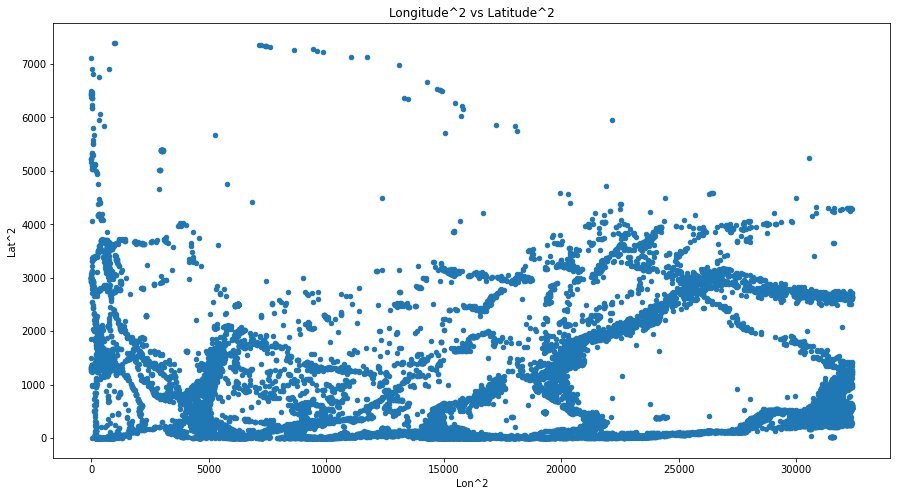

In [15]:
earthquake_data.plot.scatter(x='Lon^2', y='Lat^2', figsize=(15, 8), title='Longitude^2 vs Latitude^2')

<AxesSubplot:title={'center':'sin(Lat) vs sin(Lon)'}, xlabel='sin(Lon)', ylabel='sin(Lat)'>

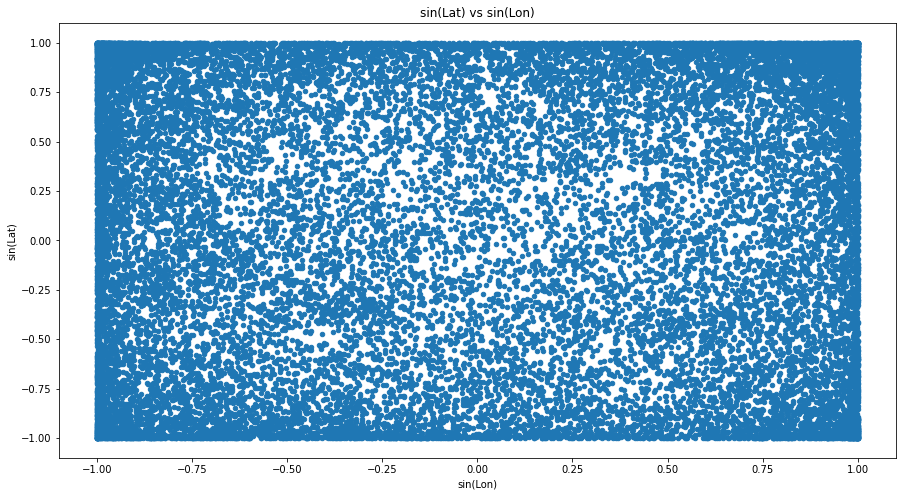

In [16]:
earthquake_data.plot.scatter(x='sin(Lon)', y='sin(Lat)', figsize=(15, 8), title='sin(Lat) vs sin(Lon)')

In [17]:
# Standardize the earthquake data // PCA
attribs = list(earthquake_data)
ct = ColumnTransformer([("num", StandardScaler(), attribs)])
earthquake_prepared = ct.fit_transform(earthquake_data)

X_train, X_test, y_train, y_test = train_test_split(earthquake_prepared, labels, test_size=0.2, random_state=42)

In [19]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", name="input"),
    keras.layers.Dense(50, activation="relu", name="h1"),
    keras.layers.Dense(50, activation="relu", name="h2"),
    keras.layers.Dense(1)
])

In [22]:
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=1000,
                   validation_data=(X_test, y_test))


mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.5797 - val_loss: 0.2051
Epoch 2/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1848 - val_loss: 0.1901
Epoch 3/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1818 - val_loss: 0.2056
Epoch 4/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1817 - val_loss: 0.1873
Epoch 5/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1807 - val_loss: 0.1962
Epoch 6/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1803 - val_loss: 0.1868
Epoch 7/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1802 - val_loss: 0.1996
Epoch 8/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1796 - val_loss: 0.2031
Epoch 9/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1798 - val_loss: 0.1870
Epoch 10/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.179

586/586 [==============================] - 1s 1ms/step - loss: 0.1769 - val_loss: 0.1889
Epoch 81/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1767 - val_loss: 0.1867
Epoch 82/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1764 - val_loss: 0.1885
Epoch 83/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1765 - val_loss: 0.2113
Epoch 84/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1765 - val_loss: 0.1913
Epoch 85/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1766 - val_loss: 0.1847
Epoch 86/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1763 - val_loss: 0.2050
Epoch 87/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1763 - val_loss: 0.1970
Epoch 88/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1765 - val_loss: 0.1876
Epoch 89/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1766 - v

586/586 [==============================] - 1s 1ms/step - loss: 0.1757 - val_loss: 0.1844
Epoch 160/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1755 - val_loss: 0.1847
Epoch 161/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1756 - val_loss: 0.1835
Epoch 162/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1757 - val_loss: 0.1856
Epoch 163/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - val_loss: 0.1827
Epoch 164/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - val_loss: 0.1992
Epoch 165/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1755 - val_loss: 0.1876
Epoch 166/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1756 - val_loss: 0.1854
Epoch 167/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - val_loss: 0.1900
Epoch 168/1000
586/586 [==============================] - 1s 1ms/step - loss: 0

Epoch 238/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1746 - val_loss: 0.1847
Epoch 239/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1749 - val_loss: 0.1830
Epoch 240/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1744 - val_loss: 0.1908
Epoch 241/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1747 - val_loss: 0.1854
Epoch 242/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1745 - val_loss: 0.1856
Epoch 243/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1745 - val_loss: 0.1910
Epoch 244/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1749 - val_loss: 0.1921
Epoch 245/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1748 - val_loss: 0.1861
Epoch 246/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1746 - val_loss: 0.1858
Epoch 247/1000
586/586 [==============================] - 1s 1ms

Epoch 317/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1740 - val_loss: 0.1849
Epoch 318/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1741 - val_loss: 0.1911
Epoch 319/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1741 - val_loss: 0.1829
Epoch 320/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1741 - val_loss: 0.1843
Epoch 321/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1741 - val_loss: 0.1833
Epoch 322/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1739 - val_loss: 0.1824
Epoch 323/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1738 - val_loss: 0.1867
Epoch 324/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1737 - val_loss: 0.1882
Epoch 325/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1738 - val_loss: 0.1826
Epoch 326/1000
586/586 [==============================] - 1s 1ms

Epoch 396/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1736 - val_loss: 0.1825
Epoch 397/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1736 - val_loss: 0.1830
Epoch 398/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1735 - val_loss: 0.1880
Epoch 399/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1736 - val_loss: 0.1828
Epoch 400/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1735 - val_loss: 0.1822
Epoch 401/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1737 - val_loss: 0.1846
Epoch 402/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1735 - val_loss: 0.1861
Epoch 403/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1734 - val_loss: 0.1941
Epoch 404/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1737 - val_loss: 0.1832
Epoch 405/1000
586/586 [==============================] - 1s 1ms

Epoch 475/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1733 - val_loss: 0.1841
Epoch 476/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1732 - val_loss: 0.1821
Epoch 477/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1733 - val_loss: 0.1836
Epoch 478/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1733 - val_loss: 0.1887
Epoch 479/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1734 - val_loss: 0.1824
Epoch 480/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1731 - val_loss: 0.1835
Epoch 481/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1732 - val_loss: 0.1831
Epoch 482/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1731 - val_loss: 0.1875
Epoch 483/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1733 - val_loss: 0.1831
Epoch 484/1000
586/586 [==============================] - 1s 1ms

Epoch 554/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1729 - val_loss: 0.1840
Epoch 555/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1727 - val_loss: 0.2047
Epoch 556/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1728 - val_loss: 0.1930
Epoch 557/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1726 - val_loss: 0.1893
Epoch 558/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1729 - val_loss: 0.1841
Epoch 559/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1727 - val_loss: 0.1877
Epoch 560/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1727 - val_loss: 0.1825
Epoch 561/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1729 - val_loss: 0.1831
Epoch 562/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1725 - val_loss: 0.1851
Epoch 563/1000
586/586 [==============================] - 1s 1ms

Epoch 633/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1726 - val_loss: 0.1831
Epoch 634/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1723 - val_loss: 0.1880
Epoch 635/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1725 - val_loss: 0.1854
Epoch 636/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1726 - val_loss: 0.1888
Epoch 637/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1725 - val_loss: 0.1859
Epoch 638/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1726 - val_loss: 0.1823
Epoch 639/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1727 - val_loss: 0.1856
Epoch 640/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1725 - val_loss: 0.1830
Epoch 641/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1722 - val_loss: 0.1842
Epoch 642/1000
586/586 [==============================] - 1s 1ms

Epoch 712/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1721 - val_loss: 0.1942
Epoch 713/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1723 - val_loss: 0.1852
Epoch 714/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1721 - val_loss: 0.1823
Epoch 715/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1724 - val_loss: 0.1833
Epoch 716/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1723 - val_loss: 0.1845
Epoch 717/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1721 - val_loss: 0.1828
Epoch 718/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1720 - val_loss: 0.1859
Epoch 719/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1720 - val_loss: 0.1912
Epoch 720/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1719 - val_loss: 0.1847
Epoch 721/1000
586/586 [==============================] - 1s 1ms

Epoch 791/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1720 - val_loss: 0.1917
Epoch 792/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1718 - val_loss: 0.1834
Epoch 793/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1719 - val_loss: 0.1860
Epoch 794/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1719 - val_loss: 0.1837
Epoch 795/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1721 - val_loss: 0.1845
Epoch 796/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1721 - val_loss: 0.1873
Epoch 797/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1718 - val_loss: 0.1868
Epoch 798/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1720 - val_loss: 0.1839
Epoch 799/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1718 - val_loss: 0.1842
Epoch 800/1000
586/586 [==============================] - 1s 1ms

Epoch 870/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1715 - val_loss: 0.1921
Epoch 871/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1717 - val_loss: 0.1958
Epoch 872/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1716 - val_loss: 0.1866
Epoch 873/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1715 - val_loss: 0.1834
Epoch 874/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1715 - val_loss: 0.1862
Epoch 875/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1715 - val_loss: 0.1947
Epoch 876/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1718 - val_loss: 0.1830
Epoch 877/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1714 - val_loss: 0.1825
Epoch 878/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1716 - val_loss: 0.1846
Epoch 879/1000
586/586 [==============================] - 1s 1ms

586/586 [==============================] - 1s 1ms/step - loss: 0.1713 - val_loss: 0.1838
Epoch 949/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1716 - val_loss: 0.1825
Epoch 950/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1715 - val_loss: 0.1824
Epoch 951/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1712 - val_loss: 0.1891
Epoch 952/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1711 - val_loss: 0.1877
Epoch 953/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1710 - val_loss: 0.1863
Epoch 954/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1712 - val_loss: 0.1850
Epoch 955/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1711 - val_loss: 0.1839
Epoch 956/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1714 - val_loss: 0.1857
Epoch 957/1000
586/586 [==============================] - 1s 1ms/step - loss: 0

In [23]:
print(X_new)
print(y_pred)

[[ 0.42623713  0.63976722 -0.3079828   0.26925295 -0.08771957]
 [-0.81152548 -0.86336391  0.36055791 -0.05238511 -0.08771957]
 [ 1.06014588  0.80247118  0.00182875 -0.86594019 -0.08771957]]
[[5.8524685]
 [5.7636175]
 [5.705128 ]]
